# Análise sobre mortes decorrentes de complicações da Aids no ano de 2016

### Dados coletados em: DATASUS  Tecnologia da Informação a Serviço do SUS
#### Fonte: http://tabnet.datasus.gov.br

Bibliotecas importadas:

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from shapely.geometry import Point
import pysal

c:\users\matheusdacruzoliveir\appdata\local\programs\python\python36\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


### CID's 10 utilizados:

B20 Doença pelo vírus da imunodeficiência humana [HIV], resultando em doenças infecciosas e parasitárias.

B21 Doença pelo vírus da imunodeficiência humana [HIV], resultando em neoplasias malignas.

B22 Doença pelo vírus da imunodeficiência humana [HIV] resultando em outras doenças especificadas.

B23 Doença pelo vírus da imunodeficiência humana [HIV] resultando em outras doenças.

B24 Doença pelo vírus da imunodeficiência humana [HIV] não especificada.

# Importação dos dados do ano de 2006
### Após a importação, foi necessário remover os números que vinham juntos com o nome do município, alterar os nomes das colunas e deixar os nomes dos municípios com caracteres maiúsculos 

In [2]:
df2006 = pd.read_csv('./dados/dados_aids_2006.csv',sep=';',encoding='ANSI', header=4)
df2006 = df2006[:314]
listaMunicipio = []

for item in df2006['Município']:
    listaMunicipio.append(item[7:]) 
df2006['Município'] = listaMunicipio

colunas = ('municipio obitos').split()
df2006.columns = colunas
df2006.municipio = df2006.municipio.str.upper()

# Importação do shapefile do estado de São Paulo
### As colunas foram renomeadas e foi feita a junção do dado csv do ano de 2006 , com os dados tabulares do shapefile. Após a junção, foram excluidas as linhas que não possuíam valores no campo 'óbito'

In [3]:
shpdf2006 = gpd.read_file('./dados/shapefile/municipios.shp')
colunas = ('nome','geocod','geometry')
shpdf2006.columns = colunas
shpdf2006 = shpdf2006.set_index('geocod')

merged2006 = df2006.merge(shpdf2006,left_on='municipio',right_on='nome',how='outer')
merged2006 = merged2006.drop('nome',1)
merged2006 = merged2006.dropna()

# Importação dos dados do ano de 2016
### Após a importação, foi necessário remover os números que vinham juntos com o nome do município, alterar os nomes das colunas e deixar os nomes dos municípios com caracteres maiúsculos 

In [4]:
df2016= pd.read_csv('./dados/dados_aids_2016.csv', sep=';' , header=4, encoding='ANSI')
df2016 = df2016[:316]
listaMunicipio = []

for item in df2016['Município']:
    listaMunicipio.append(item[7:]) 
df2016['Município'] = listaMunicipio

colunas = ('municipio obitos').split()
df2016.columns = colunas
df2016.municipio = df2016.municipio.str.upper()

# Importação do shapefile do estado de São Paulo
### As colunas foram renomeadas e foi feita a junção do dado csv do ano de 2016 , com os dados tabulares do shapefile. Após a junção, foram excluidas as linhas que não possuíam valores no campo 'óbito' 

In [5]:
shpdf2016 = gpd.read_file('./dados/shapefile/municipios.shp')
colunas = ('nome','geocod','geometry')
shpdf2016.columns = colunas
shpdf2016 = shpdf2016.set_index('geocod')

merged2016 = df2016.merge(shpdf2016,left_on='municipio',right_on='nome',how='outer')
merged2016 = merged2016.drop('nome',1)
merged2016 = merged2016.dropna()

# Total de óbitos no ano de 2006

In [6]:
df2006['obitos'].sum()

3209.0

# Total de óbitos no ano de 2016

In [7]:
df2016['obitos'].sum()

2523.0

# Analise estatística descritivas que resumem a tendência central, a dispersão e a forma da distribuição de um conjunto de dados, excluindo os valores NaN. Ano 2006

In [8]:
df2006.describe()

,obitos
count,314.000000
mean,10.219745
std,59.419767
min,1.000000
25%,1.000000
50%,2.000000
75%,6.000000
max,1038.000000


# Analise estatística descritivas que resumem a tendência central, a dispersão e a forma da distribuição de um conjunto de dados, excluindo os valores NaN. Ano 2016

In [9]:
df2016.describe()

,obitos
count,316.000000
mean,7.984177
std,39.704261
min,1.000000
25%,1.000000
50%,2.000000
75%,6.000000
max,692.000000


#  Os 10 municípios com mais óbitos - Ano 2006

In [10]:
df2006.sort_values(by=['obitos'],ascending=False).head(10)

,municipio,obitos
274,SÃO PAULO,1038.0
241,RIBEIRÃO PRETO,86.0
106,GUARULHOS,70.0
262,SANTOS,69.0
261,SANTO ANDRÉ,63.0
55,CAMPINAS,58.0
270,SÃO JOSÉ DO RIO PRETO,53.0
192,OSASCO,52.0
35,BAURU,49.0
283,SOROCABA,45.0


#  Os 10 municípios com mais óbitos - Ano 2016

In [11]:
df2016.sort_values(by=['obitos'],ascending=False).head(10)

,municipio,obitos
277,SÃO PAULO,692.0
48,CAMPINAS,69.0
96,GUARULHOS,54.0
265,SANTOS,46.0
241,RIBEIRÃO PRETO,41.0
281,SÃO VICENTE,40.0
187,OSASCO,40.0
263,SANTO ANDRÉ,39.0
287,SOROCABA,38.0
95,GUARUJÁ,35.0


#  Total de óbitos - Ano 2006

In [12]:
merged2006['obitos'].count()

313

#  Total de óbitos - Ano 2016

In [13]:
merged2016['obitos'].count()

316

#### Para gerar o gráfico de barras, foram selecionados os 10 municípios com os maiores índices do ano de 2006

Text(0.5, 1.0, 'Os 10 municípios com maiores índices no estado de São Paulo - 2006')

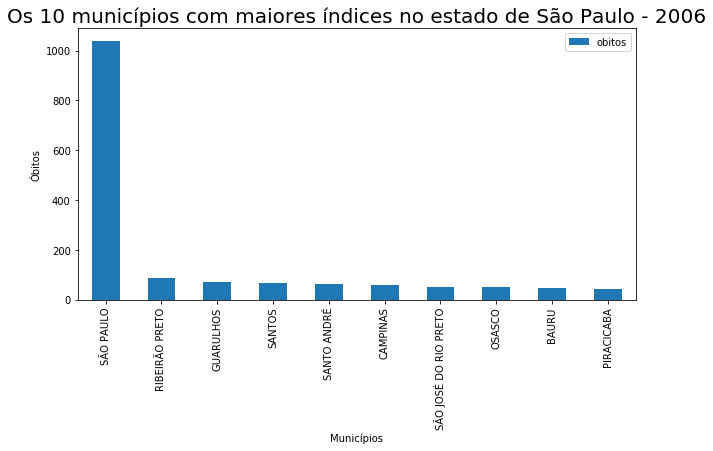

In [14]:
merged2006.sort_values(by=['obitos'],ascending=False).head(10).plot(figsize=(10,5),x='municipio',kind='bar')
plt.ylabel('Óbitos')
plt.xlabel('Municípios')
plt.title('Os 10 municípios com maiores índices no estado de São Paulo - 2006',fontsize=20)


#### Para gerar o gráfico de barras, foram selecionados os 10 municípios com os maiores índices do ano de 2016

Text(0.5, 1.0, 'Os 10 municípios com maiores índices no estado de São Paulo - 2016')

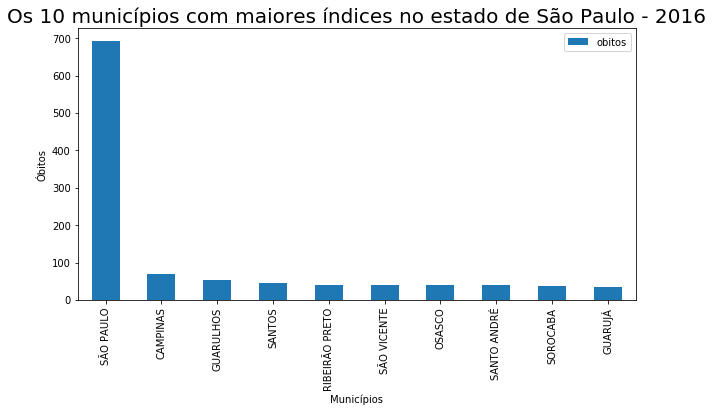

In [15]:
merged2016.sort_values(by=['obitos'],ascending=False).head(10).plot(figsize=(10,5),x='municipio',kind='bar')
plt.ylabel('Óbitos')
plt.xlabel('Municípios')
plt.title('Os 10 municípios com maiores índices no estado de São Paulo - 2016',fontsize=20)


### Para gerar o mapa, foi necessário transformar o Dataframe em Geodataframe.
### Foram selecionados os 20 municípios com os maiores índices.
### O método para fazer a divisão da classificação, foi o Fisher Jenks
### Ano 2006

Text(0.5, 1.0, 'Mortes decorrentes de complicações da Aids - 2006')

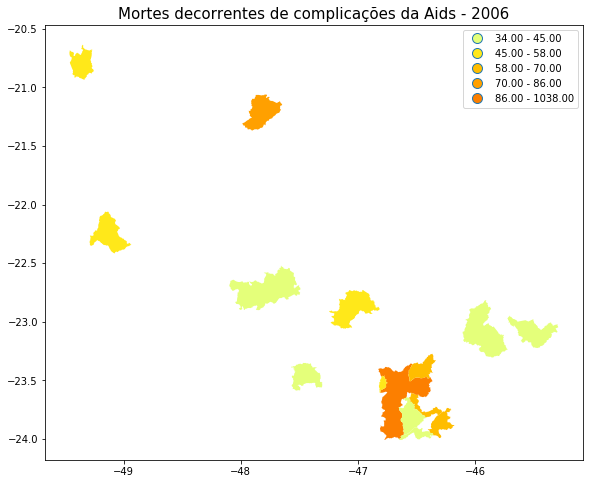

In [16]:
mergedgdf2006 = GeoDataFrame(merged2006, crs=4674, geometry='geometry')

maioresgdf2006 = mergedgdf2006.sort_values(by=['obitos'],ascending=False).head(15)
maioresgdf2006.plot(column = 'obitos', figsize=(18,8),cmap='Wistia', scheme='fisher_jenks', legend=True)
plt.title('Mortes decorrentes de complicações da Aids - 2006',fontsize=15)

### Para gerar o mapa, foi necessário transformar o Dataframe em Geodataframe.
### Foram selecionados os 20 municípios com os maiores índices.
### O método para fazer a divisão da classificação, foi o Fisher Jenks
### Ano 2016

Text(0.5, 1.0, 'Mortes decorrentes de complicações da Aids - 2016')

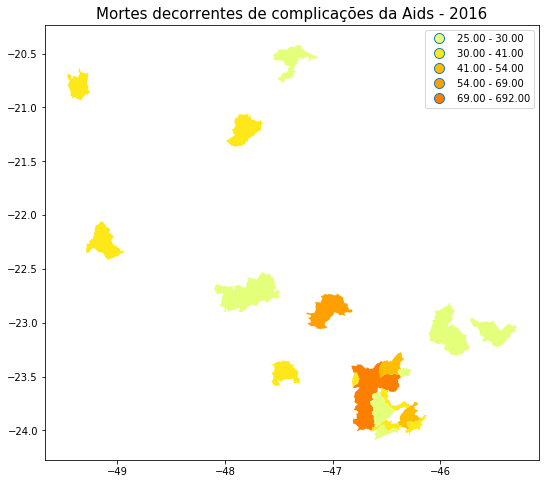

In [17]:
mergedgdf2016 = GeoDataFrame(merged2016, crs=4674, geometry='geometry')

maioresgdf2016 = mergedgdf2016.sort_values(by=['obitos'],ascending=False).head(20)
maioresgdf2016.plot(column = 'obitos', figsize=(18,8),cmap='Wistia', scheme='fisher_jenks', legend=True)
plt.title('Mortes decorrentes de complicações da Aids - 2016',fontsize=15)

### Criação do mapa com todos os municípios que possuem mortes. Ano 2006

Text(0.5, 1.0, 'Mortes decorrentes de complicações da Aids - Estado de São Paulo - 2006')

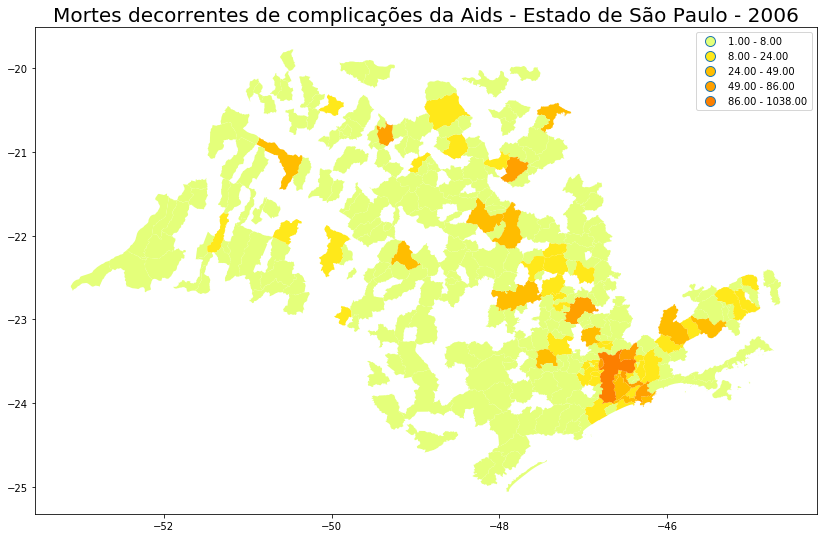

In [18]:
mergedgdf2006.plot(column = 'obitos', figsize=(14,11),cmap='Wistia', scheme='fisher_jenks', legend=True)
plt.title('Mortes decorrentes de complicações da Aids - Estado de São Paulo - 2006',fontsize=20)

### Criação do mapa com todos os municípios que possuem mortes. Ano 2016 

Text(0.5, 1.0, 'Mortes decorrentes de complicações da Aids - Estado de São Paulo - 2016')

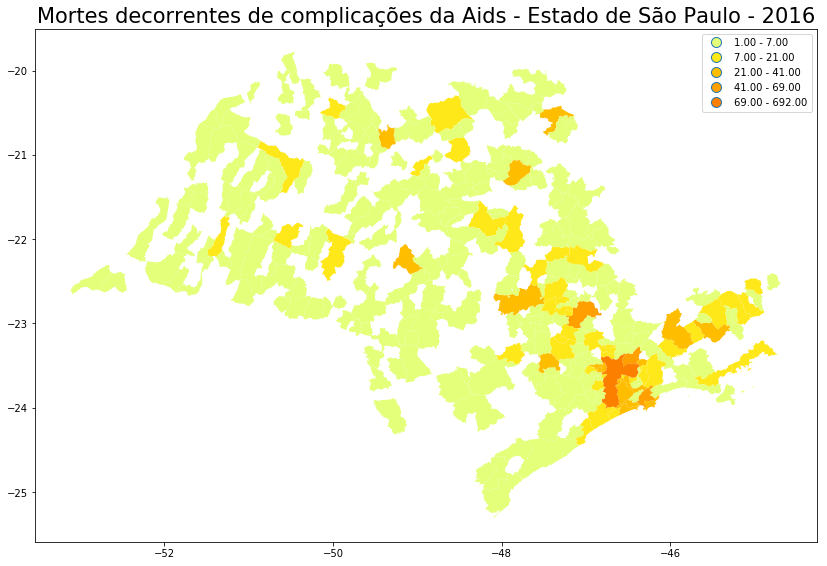

In [19]:
mergedgdf2016.plot(column = 'obitos', figsize=(14,11),cmap='Wistia', scheme='fisher_jenks', legend=True)
plt.title('Mortes decorrentes de complicações da Aids - Estado de São Paulo - 2016',fontsize=21)

Text(0.5, 0, 'Anos')

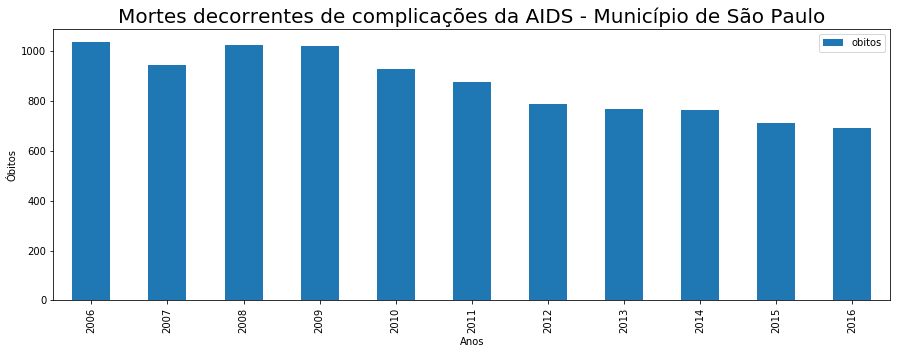

In [20]:
anos_sp = pd.read_csv('./dados/anos_sp.csv',sep=';',encoding='ANSI')
anos_sp.plot(kind='bar',x='ano', figsize=(15,5))
plt.title('Mortes decorrentes de complicações da AIDS - Município de São Paulo',fontsize=20)
plt.ylabel('Óbitos')
plt.xlabel('Anos')

# Conclusão
### Ao realizar este trabalho, cheguei a conclusão que há uma concentração das mortes decorrentes da AIDS, no município de São Paulo e ao seu redor, permanecendo recorrente no intervalo de dez anos. São Paulo é a cidade onde tem o maior número de casos, no ano de 2016, os números são 10 vezes maiores que o segundo colocado, Campinas. Dentre os anos de 2006 e 2016 houve uma queda no número de vítimas, foi de 1038, para 692, sendo assim, uma redução de 34%. 